<img src="images/GEMS long.png" width=600 alt="GEMS Logo" title="GEMS" />

# **Geocomputation with Raster Data**

**Instructors:**  
Yuan Chai (chaix026@umn.edu)  
Ali Joglekar (joglekar@umn.edu)  

---

## Method of Delivery
- Workshop text, images and R code are all contained within a Jupyter Notebook hosted on the GEMS Informatics Platform. You do not need to have R or RStudio installed on your machine to participate
- A recording of the workshop will be posted on Canvas
- Please download any desired materials, as we cannot guarantee access to the Canvas course beyond 3 months.  

---  

## Module Outline: 
- [Raster data in R](#Raster)  
  - [Exercise 1](#Ex1)
- [Raster manipulation](#Manipulation) 
- [Spatial operations](#SpOp)
  - [Exercise 2](#Ex2)
- [Geometry operations](#GeomOp)  
  - [Exercise 3](#Ex3)
- [Raster-Vector interactions](#RasVec)
  - [Exercise 4](#Ex4)

---  


### **Load R Libraries**

In [1]:
# Install and load packages needed for this workshop

packages_to_load <- c("raster", "sf", "tmap", "data.table")

for ( package in packages_to_load ) {
    # Check if package is already installed, if not, install and load the package
    if (!require(package, character.only=T, quietly=T, warn.conflicts=F)) {
        install.packages(package)
        suppressPackageStartupMessages(library(package, character.only=T, quietly=T, warn.conflicts=F))
    }
}

# Set plot options
options(repr.plot.width = 8, repr.plot.height = 4)


Linking to GEOS 3.10.2, GDAL 3.4.1, PROJ 8.2.1; sf_use_s2() is TRUE



<details>
    
<summary><span style='color:Green'> Note: For your own work, once packages are installed, it is recommended to just use library() to load your packages  </span></summary>


```
# Spatial data libraries
library(raster)
library(sf)

# Plotting libraries
library(tmap)

# General data analysis libraries
library(data.table)
```
----
          
</details>


### Data

Your expercises will draw on datasets from the Spatial Production Allocation Model (SPAM) and Minnesota Geospatial Commons, which have been downloaded, cleaned, transformed and saved in the directory `./data/MN` for this workshop.

1. \[RASTERS\] Crop production at 10x10km grid-cell resolution from MAPSPAM (Spatial Production Allocation Model) data center  https://www.mapspam.info/data/
2. \[POLYGONS\] Groundwater Provinces of Minnesota 2021: https://gisdata.mn.gov/dataset/geos-groundwater-provinces-mn


### Attribution

The following material draws heavily from Robin Lovelace's [Geocomputation with R](https://geocompr.robinlovelace.net/index.html) textbook.

<a id="Raster"></a>
## **What is raster data?**

In its simplest form, a raster consists of a matrix of cells (or pixels) organized into rows and columns (or a grid) where each cell contains a value representing information, such as temperature.  
Rasters can be digital aerial photographs, imagery from satellites, digital pictures, or even scanned maps.

<img src="https://desktop.arcgis.com/en/arcmap/latest/manage-data/raster-and-images/GUID-6754AF39-CDE9-4F9D-8C3A-D59D93059BDD-web.png" />


### **Creating `Raster*` objects in R**

In this workshop, we will focus on using the `raster` package for raster data analysis in R, mainly due to its compabilities with other existing packages.  
A newer package `terra` is designed to replace the old favourite `raster`. It is made by a similar team. The `terra` documentation states “can do more, is simpler to use, and it is faster.” The transition from `raster` to `terra` is relatively straightforward so it is recommended that you learn `terra` for your own work once you have mastered the basic operations of `raster` to take advantage of the faster `terra` package. 


Raster data structure in R:  
- Number of rows
- Number of columns
- Bounding box (extent)
- Resolution
- Coordinate reference system (projection)  

Create an empty `RasterLayer` with 6 rows and 6 columns within bounding box (-1.5, 1.5, -1.5, 1.5)

In [2]:
ras <- raster(nrows = 6, ncols = 6, xmn = -1.5, xmx = 1.5, ymn = -1.5, ymx = 1.5)
ras

class      : RasterLayer 
dimensions : 6, 6, 36  (nrow, ncol, ncell)
resolution : 0.5, 0.5  (x, y)
extent     : -1.5, 1.5, -1.5, 1.5  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 



The objects `ras` created in the example above only consist of the raster ‘geometry’, that is, we have defined the number of rows and columns, and where the raster is located in geographic space, but there are no cell-values associated with it. 

Setting and accessing values using the `values()` function


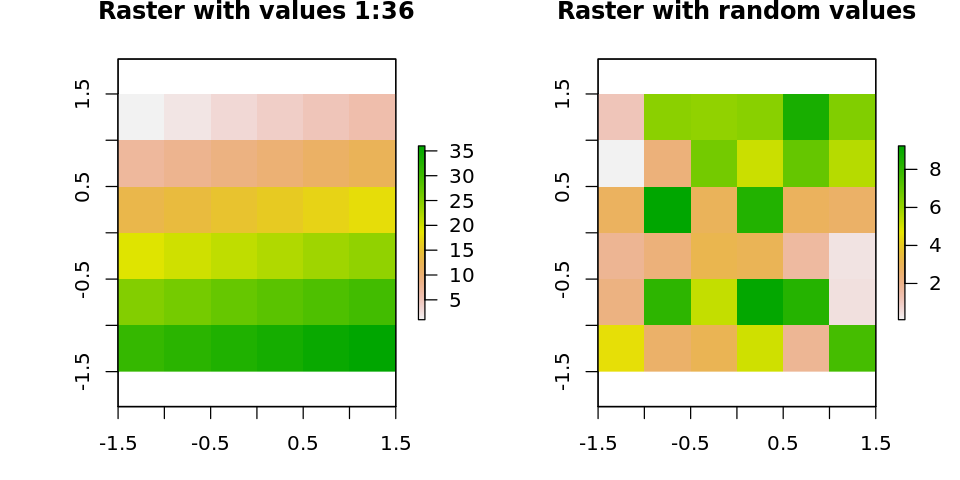

In [3]:
# Assign know values to raster cells
ras_a <- ras
values(ras_a) <- 1:ncell(ras_a)

# Assign random values to raster cells
ras_b <- ras
set.seed(1234)
values(ras_b) <- runif(ncell(ras_b))*10

# plot two rasters
par(mfrow=c(1,2))
plot(ras_a, main="Raster with values 1:36")
plot(ras_b, main="Raster with random values")

### Attributes
Raster cells can only possess one value which can be linked to other attributes via attribute table stored in `attributes` slot

class      : RasterLayer 
dimensions : 6, 6, 36  (nrow, ncol, ncell)
resolution : 0.5, 0.5  (x, y)
extent     : -1.5, 1.5, -1.5, 1.5  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
source     : memory
names      : layer 
values     : 1, 3  (min, max)
attributes :
 ID VALUE
  1  clay
  2  silt
  3  sand


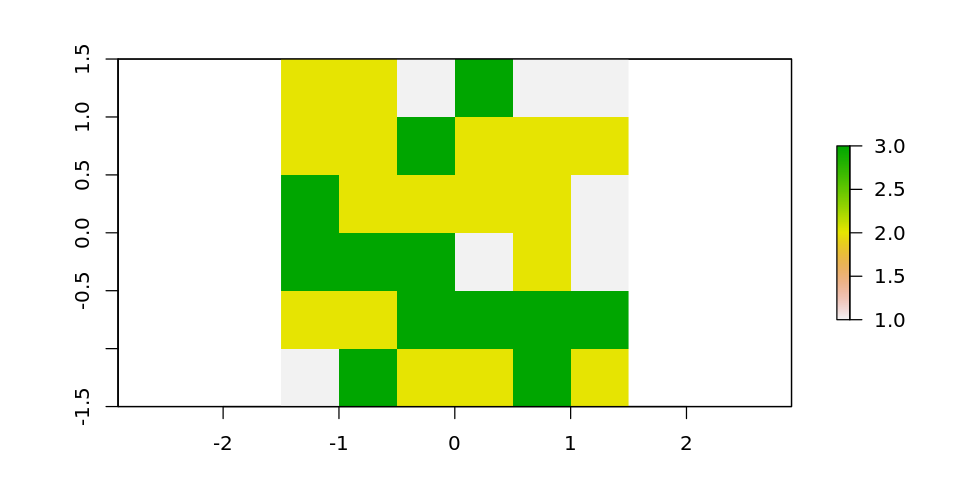

In [4]:
soil_order = c("clay", "silt", "sand")
set.seed(1234)
soil_char = sample(soil_order, 36, replace = TRUE)
soil_fact = factor(soil_char, levels = soil_order)
soil = raster(nrows = 6, ncols = 6, res = 0.5, 
               xmn = -1.5, xmx = 1.5, ymn = -1.5, ymx = 1.5,
               vals = soil_fact)
soil
plot(soil)

### Summarizing raster layer

In [5]:
nrow(ras_a) # number of rows

[1] 6

In [6]:
ncol(ras_a) # number of columns

[1] 6

In [7]:
ncell(ras_a) # number of cells

[1] 36

In [8]:
extent(ras_a) # raster extent

class      : Extent 
xmin       : -1.5 
xmax       : 1.5 
ymin       : -1.5 
ymax       : 1.5 

In [9]:
res(ras_a) # resolution

[1] 0.5 0.5

In [10]:
crs(ras_a) # coordiante reference system

Coordinate Reference System:
Deprecated Proj.4 representation: +proj=longlat +datum=WGS84 +no_defs 
WKT2 2019 representation:
GEOGCRS["unknown",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ID["EPSG",6326]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433],
        ID["EPSG",8901]],
    CS[ellipsoidal,2],
        AXIS["longitude",east,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]],
        AXIS["latitude",north,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]]] 

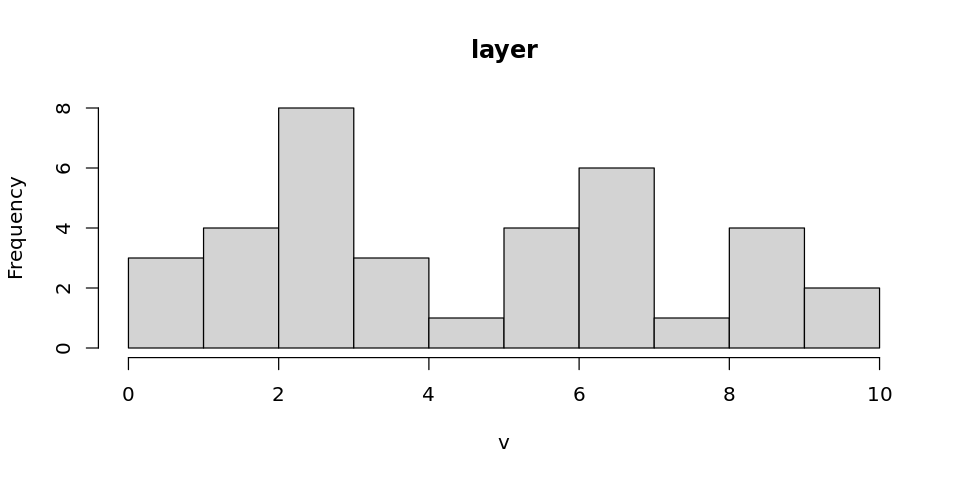

In [11]:
hist(ras_b)  # histogram of raster cell values

### Multi-layer raster stack  

A RasterStack is a collection of RasterLayer objects **with the same spatial extent and resolution**.  

In [12]:
r_stack = stack(ras_a, ras_b, soil)
names(r_stack) = c("area", "prod" , "soil")
r_stack

class      : RasterStack 
dimensions : 6, 6, 36, 3  (nrow, ncol, ncell, nlayers)
resolution : 0.5, 0.5  (x, y)
extent     : -1.5, 1.5, -1.5, 1.5  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
names      :       area,       prod,       soil 
min values : 1.00000000, 0.09495756, 1.00000000 
max values :  36.000000,   9.234335,   3.000000 


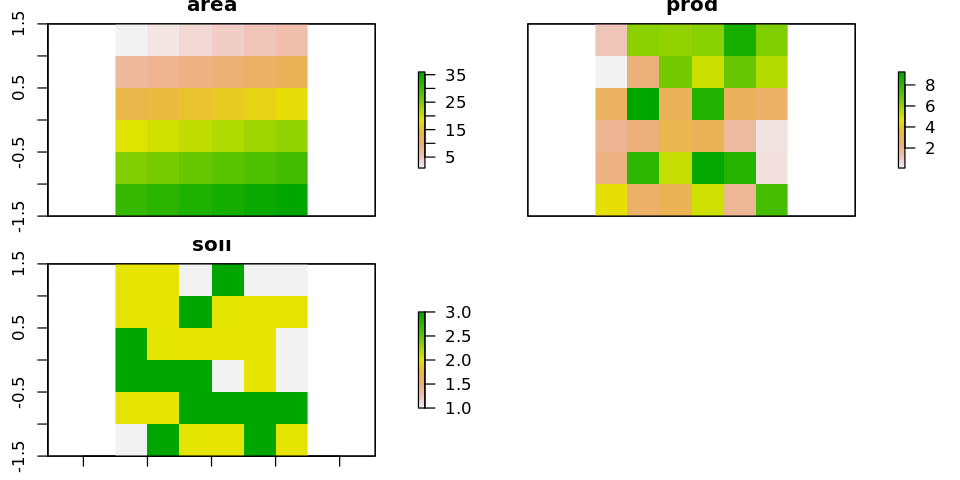

In [13]:
plot(r_stack)

<a id="Ex1"></a>
### **<span style='color:Green'> Exercise 1: Read in raster files and create raster stack </span>**   

In this exercise, we will first read in raster files (in `.tif` format) which contains the maize harvested area and production in Minnesota and then create a raster stack.  


**Step 1:** Use the `raster()` function to read in raster files from the `'./data/MN/spam/` directory.    

>file `./data/MN/spam/spam_H_MAIZ_A_mn.tif` is the Harvested Area (in hecacres) for Maize in Minnesota  
>file `./data/MN/spam/spam_P_MAIZ_A_mn.tif` is the Production (in metric tons) for Maize in Minnesota  

Use various summarizing functions (e.g., `extent()`, `res()`, `crs()`) to check the two raster files having the same extent and resolution

In [15]:
# Read in raster files
spam_H_MAIZ_A_mn <- raster("./data/MN/spam/spam_H_MAIZ_A_mn.tif")
spam_P_MAIZ_A_mn <- raster("./data/MN/spam/spam_P_MAIZ_A_mn.tif")

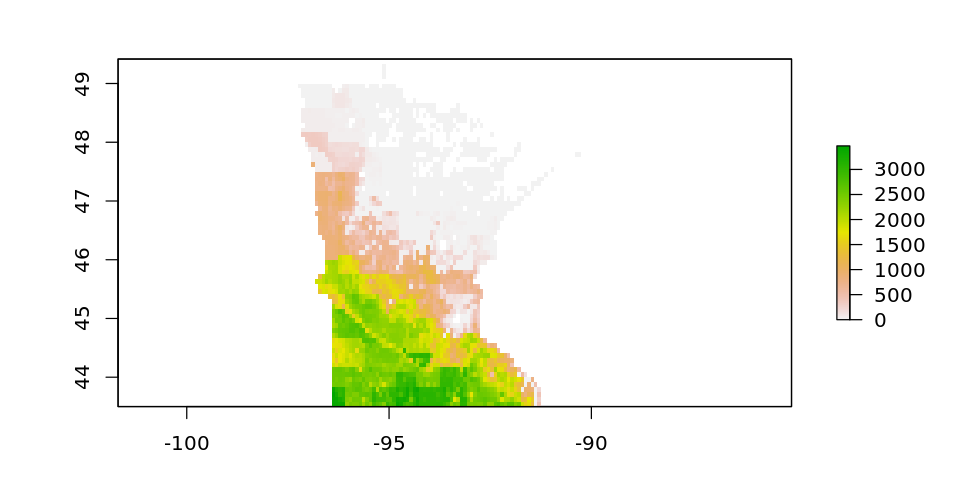

In [16]:
plot(spam_H_MAIZ_A_mn)

In [18]:
# Check for extent, resolution, and crs
res(spam_H_MAIZ_A_mn)

[1] 0.083333 0.083333

In [21]:
# crs
crs(spam_H_MAIZ_A_mn)

Coordinate Reference System:
Deprecated Proj.4 representation: +proj=longlat +datum=WGS84 +no_defs 
WKT2 2019 representation:
GEOGCRS["WGS 84 (with axis order normalized for visualization)",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]],
    REMARK["Axis order reversed compared to EPSG:4326"]] 

<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
# Read in raster files
spam_H_MAIZ_A_mn <- raster("./data/MN/spam/spam_H_MAIZ_A_mn.tif")
spam_P_MAIZ_A_mn <- raster("./data/MN/spam/spam_P_MAIZ_A_mn.tif")

# Check for extent, resolution, and crs
extent(spam_H_MAIZ_A_mn)
extent(spam_P_MAIZ_A_mn)

res(spam_H_MAIZ_A_mn)
res(spam_P_MAIZ_A_mn)

crs(spam_H_MAIZ_A_mn)
crs(spam_P_MAIZ_A_mn)
```
----
          
</details>

**Step 2:** Use `stack()` function to create a RasterStack with both Rasterlayers and rename the layers to "Area" and "Prod"    

In [23]:
spam_MAIZ_A_mn <- stack(spam_H_MAIZ_A_mn, spam_P_MAIZ_A_mn)

<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
spam_MAIZ_A_mn <- stack(spam_H_MAIZ_A_mn, spam_P_MAIZ_A_mn)
names(spam_MAIZ_A_mn) <- c("Area", "Prod")
```
----
          
</details>

**Step 3:** Use `plot()` and `hist()` functions to explore your RasterStack    

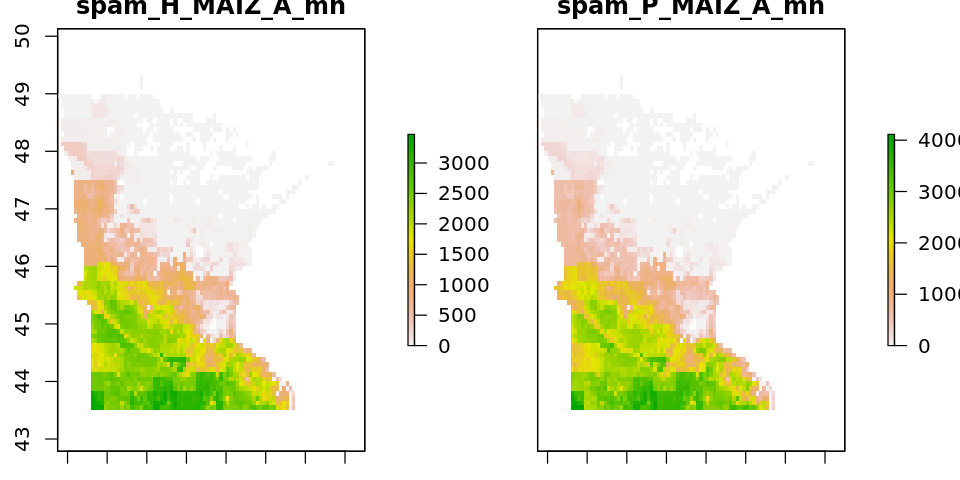

In [24]:
plot(spam_MAIZ_A_mn)

<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
plot(spam_H_MAIZ_A_mn) 
hist(spam_H_MAIZ_A_mn)

plot(spam_P_MAIZ_A_mn) 
hist(spam_P_MAIZ_A_mn)

```
----
          
</details>

<a id="Manipulation"></a>
## **Raster Manipulation**

### Raster Subset
Raster subsetting is done with the base R operator `[  ]`


In [25]:
# row 3, column 3
ras_a[3, 3]
# cell ID 15
ras_a[15]

[1] 15

[1] 15

Extracting all values or complete rows, you can use `values()` and `getValues()`

In [26]:
# all values
values(ras_a)

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36

In [27]:
# row 3-4
getValues(ras_a, row = 3, nrows = 2)

[1] 13 14 15 16 17 18 19 20 21 22 23 24

### RasterStack Subset  
The `raster::subset` command extracts layers from a multi-layer raster stack or brick. The `[]` and `$` operators can also be used.

In [28]:
# Method 1
subset(r_stack, "area")

class      : RasterLayer 
dimensions : 6, 6, 36  (nrow, ncol, ncell)
resolution : 0.5, 0.5  (x, y)
extent     : -1.5, 1.5, -1.5, 1.5  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
source     : memory
names      : area 
values     : 1, 36  (min, max)


In [29]:
# Method 2
r_stack[["area"]]

class      : RasterLayer 
dimensions : 6, 6, 36  (nrow, ncol, ncell)
resolution : 0.5, 0.5  (x, y)
extent     : -1.5, 1.5, -1.5, 1.5  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
source     : memory
names      : area 
values     : 1, 36  (min, max)


In [30]:
# Method 3
r_stack$area

class      : RasterLayer 
dimensions : 6, 6, 36  (nrow, ncol, ncell)
resolution : 0.5, 0.5  (x, y)
extent     : -1.5, 1.5, -1.5, 1.5  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
source     : memory
names      : area 
values     : 1, 36  (min, max)


<a id="SpOp"></a>
## **Spatial Operations**
Modifying raster objects based on their location and shape



### Map algebra  
Map algebra makes raster processing really fast.
This is because raster datasets only implicitly store coordinates. 
If two or more raster datasets share the same extent, projection and resolution, one could treat them as matrices for the processing.
This is exactly what map algebra is doing in R.

Map algebra divides raster operations into four subclasses, with each working on one or several grids simultaneously:

1. **Local** or per-cell operations
2. **Focal** or neighborhood operations
3. **Zonal** operations are similar to focal operations, but the surrounding pixel grid on which new values are computed can have irregular sizes and shapes
4. **Global** or per-raster operations

#### **Local operations**
**Local** operations comprise all cell-by-cell operations in one or several layers.

Many generic functions that allow for simple and elegant raster algebra have been implemented for Raster objects, including the normal algebraic operators such as `+`, `-`, `*`, `/`, logical operators such as `>`, `>=`, `<`, `==`, `!` and functions like `abs`, `round`, `ceiling`, `floor`, `trunc`, `sqrt`, `log`, `log10`, `exp`, `cos`, `sin`, `atan`, `tan`, `max`, `min`, `range`, `prod`, `sum`, `any`, `all`. In these functions you can mix raster objects with numbers, as long as the first argument is a raster object.



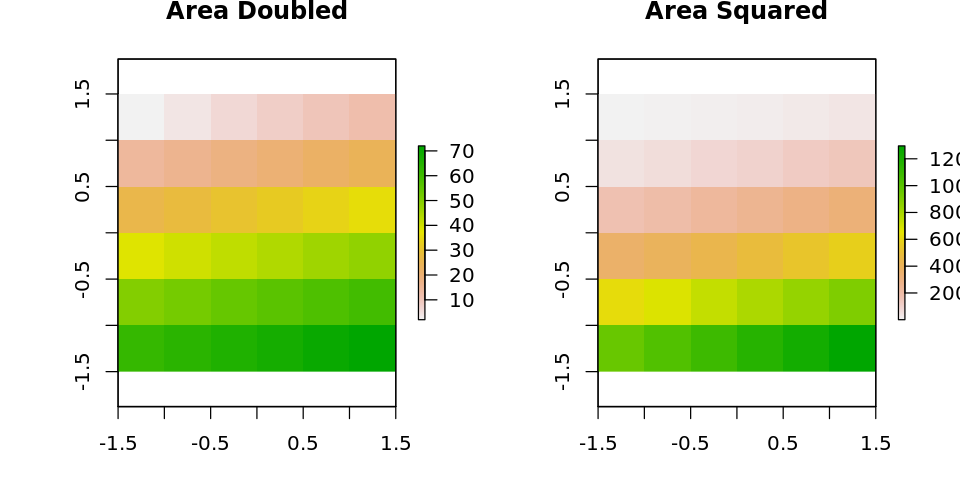

In [31]:
area <- ras_a
areaX2 <- area*2
areaSq <- area^2

# Plot
par(mfrow=c(1,2))
plot(areaX2, main="Area Doubled")
plot(areaSq, main="Area Squared")

Summary functions (`min, max, mean, prod, sum, Median, cv, range, any, all`) always return a RasterLayer object. Perhaps this is not obvious when using functions like `min, sum or mean`.

In [32]:
mean(areaX2, areaSq)

class      : RasterLayer 
dimensions : 6, 6, 36  (nrow, ncol, ncell)
resolution : 0.5, 0.5  (x, y)
extent     : -1.5, 1.5, -1.5, 1.5  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
source     : memory
names      : layer 
values     : 1.5, 684  (min, max)


Raster algebra also allows logical operations such as finding all raster cells that are greater than a specific value.  
You can also use replacement functions to change values based on logical operations.

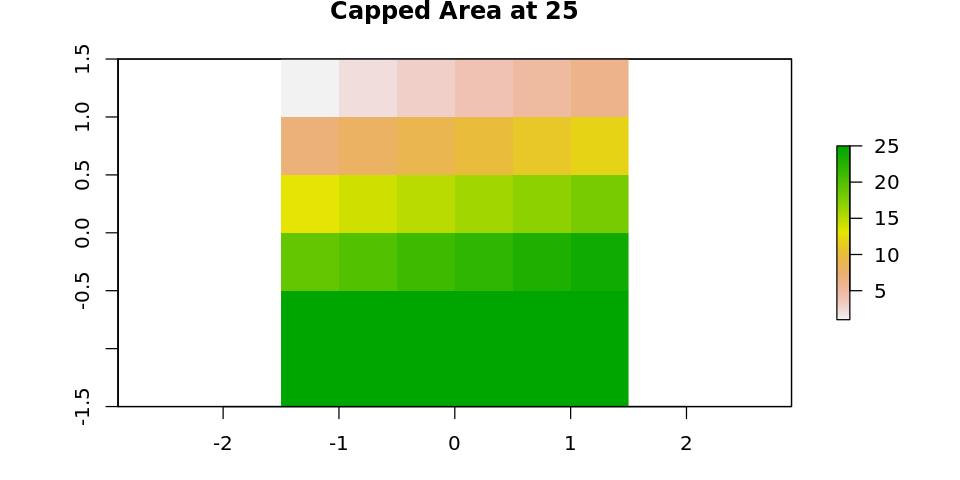

In [33]:
area_cap <- area
area_cap[area_cap >= 25 ] <- 25

# Plot
plot(area_cap, main="Capped Area at 25")

Raster algebra can also be performed on two rasterlayers

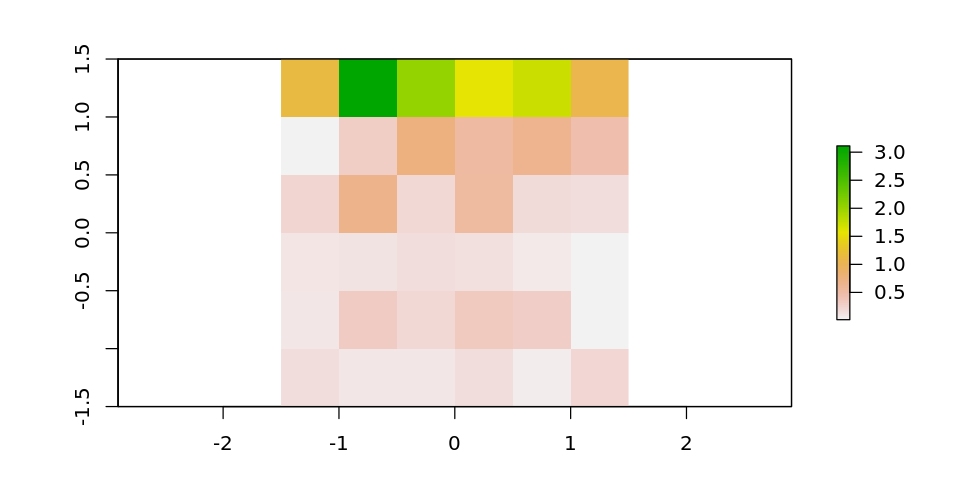

In [34]:
yield <- ras_b/ras_a
plot(yield)

#### **Focal operations**
**Focal** operations take into account a central cell and its neighbors.

The following code chunk applies an aggregation function to all cells within the 
specified neighborhood (in this case 3-by-3 cells), uses the corresponding output 
as the new value for the the central cell, and moves on to the next central cell:

<img src="images/focal_example.png" width=600 alt="GEMS Logo" title="GEMS" />

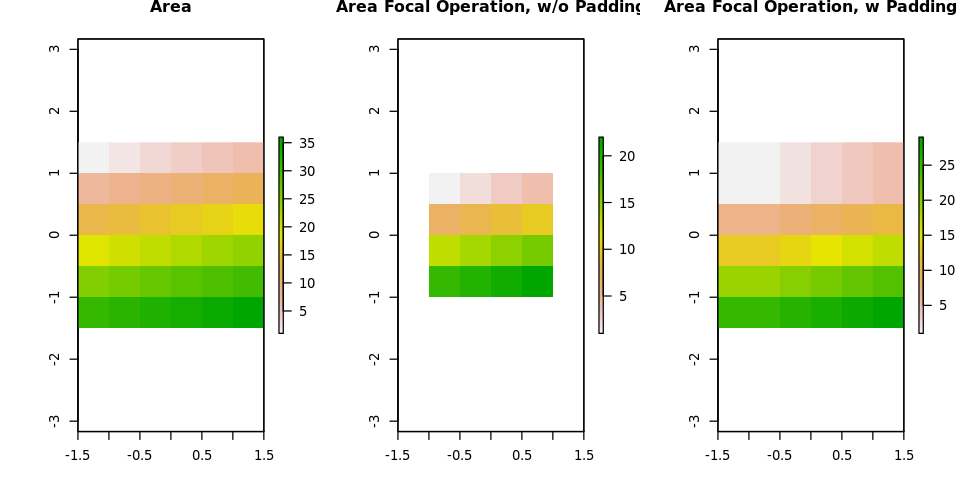

In [35]:
area_focal_1 = focal(area, w = matrix(1, nrow = 3, ncol = 3), fun = min)
area_focal_2 = focal(area, w = matrix(1, nrow = 3, ncol = 3), fun = min, na.rm=T, pad=T, padValue=NA)

# Plot
par(mfrow=c(1,3))
plot(area, main="Area")
plot(area_focal_1, main="Area Focal Operation, w/o Padding")
plot(area_focal_2, main="Area Focal Operation, w Padding")

#### **Zonal operations**
**Zonal** operations are similar to focal operations, but the filter can take on any 
shape instead of a predefined rectangular window.

The following code chunk finds the mean area for each soil type:

In [37]:
z <- zonal(area, soil, fun = "sum") 
z

zone,sum
1,109
2,290
3,267


#### **Global operations**

**Global** operations are a special case of zonal operations with the entire raster dataset representing a single zone.  
The most common global operations are descriptive statistics for the entire raster dataset such as the minimum or maximum.  
Use `cellStats` if you want a single number summarizing the cell values of each layer.

In [38]:
cellStats(area, 'max')

[1] 36

In [39]:
cellStats(area, 'sd')

[1] 10.53565

<a id="Ex2"></a>
### **<span style='color:Green'> Exercise 2: Map algebra </span>**   

In this exercise, we will practice map algebra using MN SPAM raster on maize harvested area and production.

**Step 1:** Create a RasterLayer called `spam_Y_MAIZ_A_mn` which calculates the maize yield at each grid cell in MN using the Production raster `spam_P_MAIZ_A_mn` and Harvested Area raster `spam_H_MAIZ_A_mn`.  

> Yield = Production / Harvested Area    

Plot the maize yield raster map and look at the histogram for yield distribution.


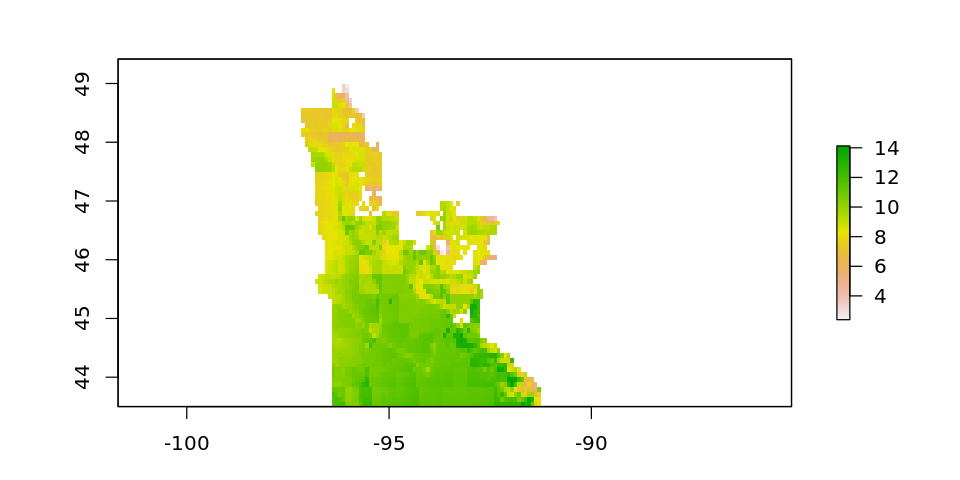

In [40]:
spam_Y_MAIZ_A_mn <- spam_P_MAIZ_A_mn / spam_H_MAIZ_A_mn
plot(spam_Y_MAIZ_A_mn)

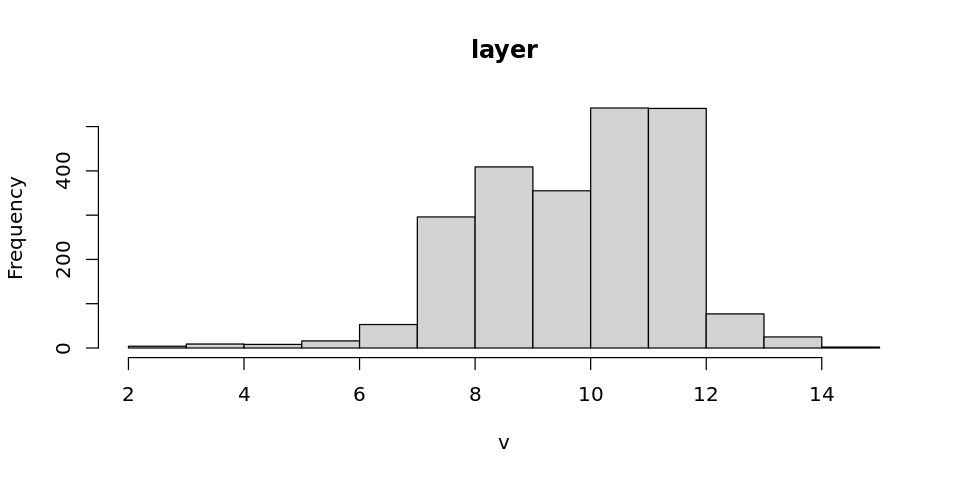

In [41]:
hist(spam_Y_MAIZ_A_mn)

<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
# Read in raster files
spam_Y_MAIZ_A_mn <- spam_P_MAIZ_A_mn / spam_H_MAIZ_A_mn

# Plot map
plot(spam_Y_MAIZ_A_mn)

# Histogram
hist(spam_Y_MAIZ_A_mn)
```
----
          
</details>

**Step 2:** Use `focal()` function to create a RasterLayer which calcualtes the mean yield within 3x3 neighborhood grid cells. Then create a raster map that displays the difference between each grid cell's yield and "mean" yield of its neighborhood   

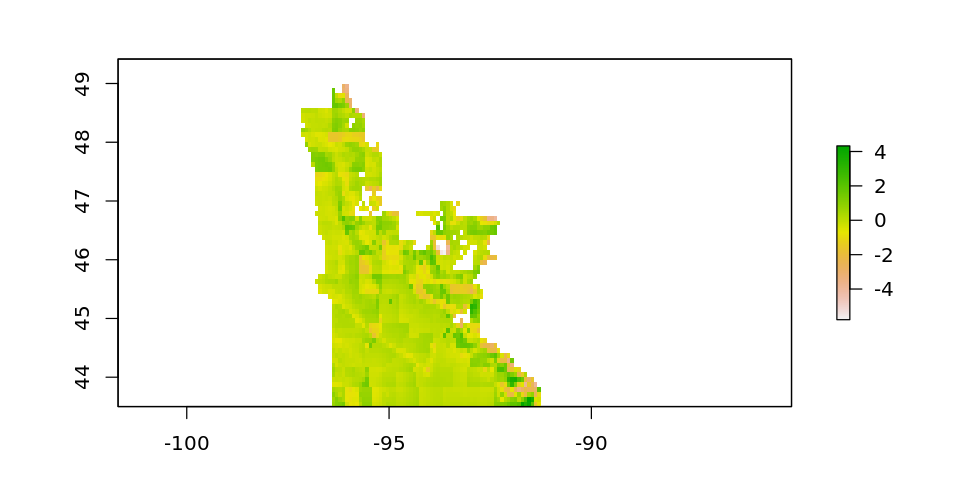

In [44]:
spam_Y_MAIZ_A_mn_focal <- focal(spam_Y_MAIZ_A_mn, w = matrix(1, nrow = 9, ncol = 9), fun = mean, na.rm=T, pad=T, padValue=NA)
spam_Y_MAIZ_A_mn_diff <- spam_Y_MAIZ_A_mn - spam_Y_MAIZ_A_mn_focal
plot(spam_Y_MAIZ_A_mn_diff)

<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
# focal calculation
spam_Y_MAIZ_A_mn_focal <- focal(spam_Y_MAIZ_A_mn, w = matrix(1, nrow = 3, ncol = 3), fun = mean, na.rm=T, pad=T, padValue=NA)

# plot the yield difference
spam_Y_MAIZ_A_mn_diff <- spam_Y_MAIZ_A_mn - spam_Y_MAIZ_A_mn_focal
plot(spam_Y_MAIZ_A_mn_diff)
```
----
          
</details>

**Step 3:** What's the maximum yield and what's the standard deviation for yield distribution in MN?    

In [43]:
cellStats(spam_Y_MAIZ_A_mn, 'max')
cellStats(spam_Y_MAIZ_A_mn, 'sd')

[1] 14.12733

[1] 1.663093

<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
cellStats(spam_Y_MAIZ_A_mn, 'max')
cellStats(spam_Y_MAIZ_A_mn, 'sd')
```
----
          
</details>

<a id="GeomOp"></a>

## **Geometry operations**

Modifying geometric objects based on their geometry


### Trim and extend

`trim` crops a RasterLayer by removing the outer rows and columns that only contain NA values.  
In contrast, `extend` adds new rows and/or columns with NA values.  
The purpose of this could be to create a new RasterLayer with the same Extent of another, larger, RasterLayer such that they can be used together in other functions.

In [45]:
area_1 <- area
extent(area_1)

class      : Extent 
xmin       : -1.5 
xmax       : 1.5 
ymin       : -1.5 
ymax       : 1.5 

In [46]:
area_2 <- extend(area, c(1, 2)) 
extent(area_2)

class      : Extent 
xmin       : -2.5 
xmax       : 2.5 
ymin       : -2 
ymax       : 2 

In [47]:
area_3 <- trim(area_2)
extent(area_3)

class      : Extent 
xmin       : -1.5 
xmax       : 1.5 
ymin       : -1.5 
ymax       : 1.5 

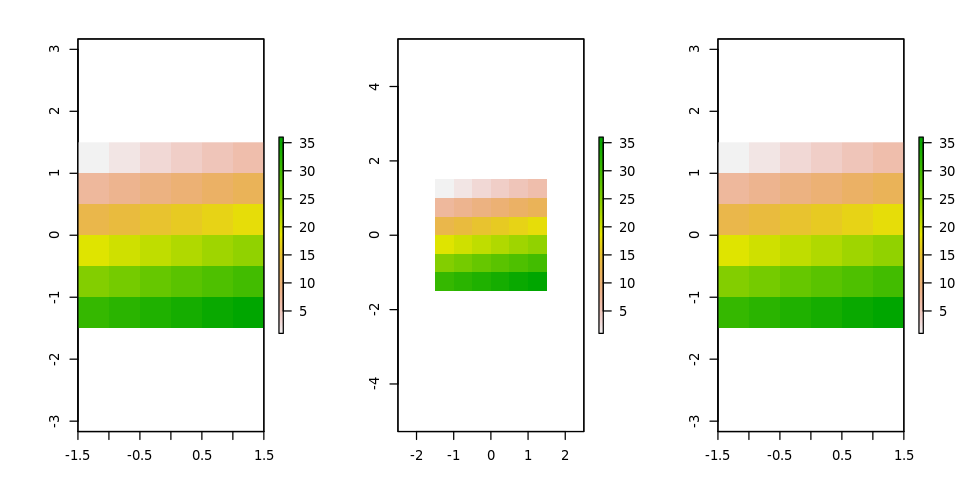

In [48]:
par(mfrow=c(1,3))
plot(area_1)
plot(area_2)
plot(area_3)

### Crop and Merge

The `crop` function lets you take a geographic subset of a larger raster object. You can crop a Raster by providing an extent object or another spatial object from which an extent can be extracted (objects from classes deriving from Raster and from Spatial in the `sp` package). 

The `merge` function lets you merge 2 or more Raster objects into a single new object. The input objects must have the same resolution and origin (such that their cells neatly fit into a single larger raster).

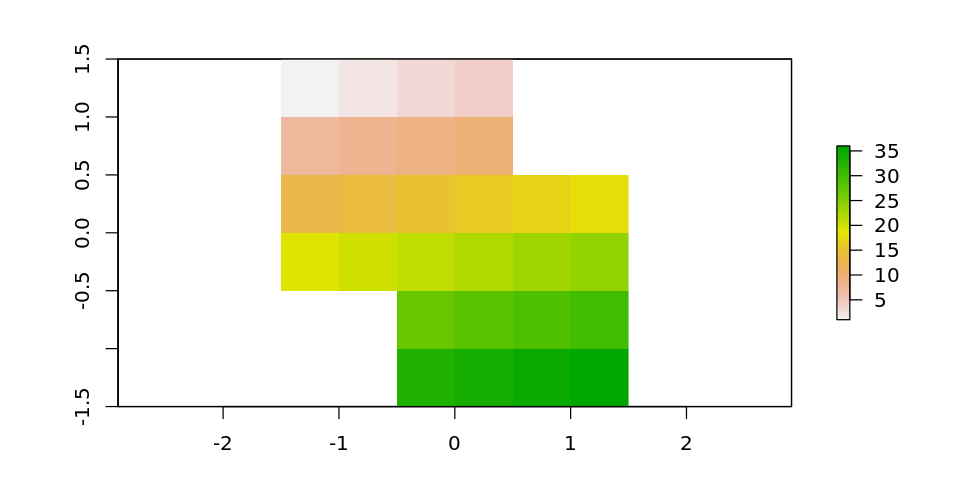

In [49]:
area_c1 = crop(area, extent(-1.5, 0.5, -0.5, 1.5))
area_c2 = crop(area, extent(-0.5, 1.5, -1.5, 0.5))
area_c1c2 = merge(area_c1, area_c2)
plot(area_c1c2)

In [53]:
?raster::mosaic

mosaic {raster},R Documentation
x,Raster* object
y,Raster* object
...,Additional Raster or Extent objects (and/or arguments for writing files as in writeRaster)
fun,"Function. E.g. mean, min, or max. Must be a function that accepts a 'na.rm' argument"
tolerance,Numeric. permissible difference in origin (relative to the cell resolution). See all.equal
filename,Character. Output filename (optional)


### Aggregation & disaggregation
`aggregate` and `disaggregate` allow for changing the resolution (cell size) of a `Raster` object. In the case of aggregate, you need to specify a function determining what to do with the grouped cell values. It is possible to specify different (dis)aggregation factors in the x and y direction. `aggregate` and `disaggregate` are the best functions when adjusting cells size only, with an integer step (e.g. each side 2 times smaller or larger). 

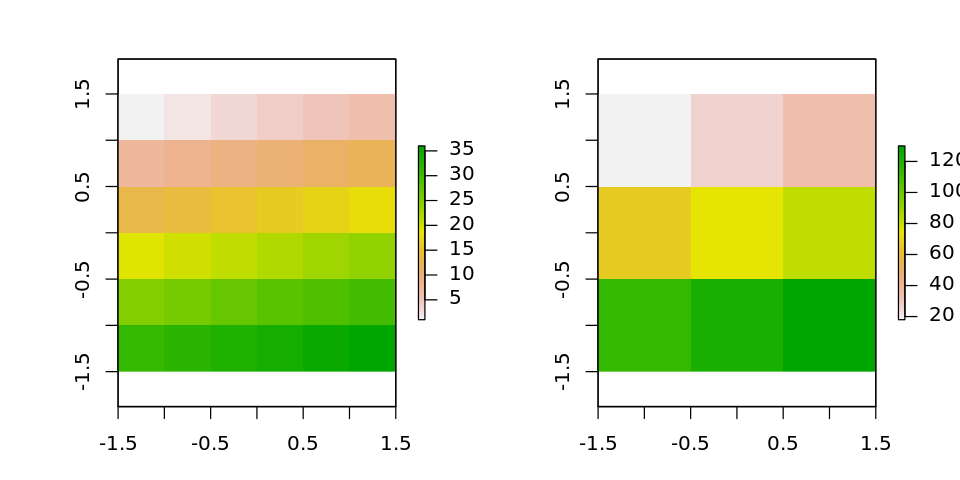

In [54]:
area_agg = aggregate(area, fact=2, fun=sum)

# quick plot
par(mfrow=c(1,2))
plot(area)
plot(area_agg)

To disaggregate a raster object you  have to specify a method on how to fill the new cells.

- **Nearest neighbor** (Default method, `method = ""`): gives all output cells the value of the nearest input cell
- **Bilinear interoploation** (`method = "bilinear"`): uses four nearest pixel centers of the input image to compute an average weighted by distance as the value of the output cell  

Disaggregating is a simple interpolation technique

Corresponding values are only as accurate as their lower resolution source

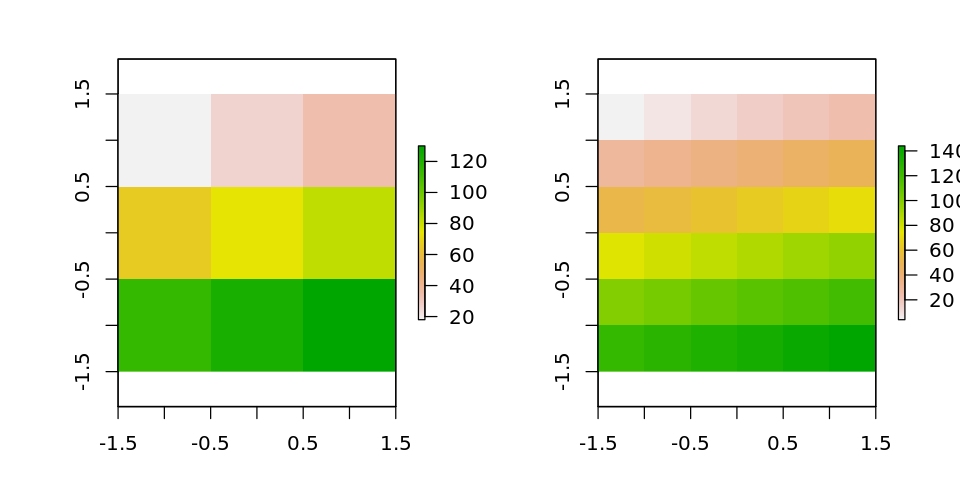

In [55]:
area_nb = disaggregate(area_agg, fact=2)
area_bi = disaggregate(area_agg, fact=2, method = "bilinear")

# plot
par(mfrow=c(1,2))
plot(area_nb)
plot(area_bi)

### Reclassify
You can use `reclassify` or `cut` to replace ranges of values with single values, or `subs` to substitute (replace) single values with other values.

0,12,1
12,24,2
24,36,3


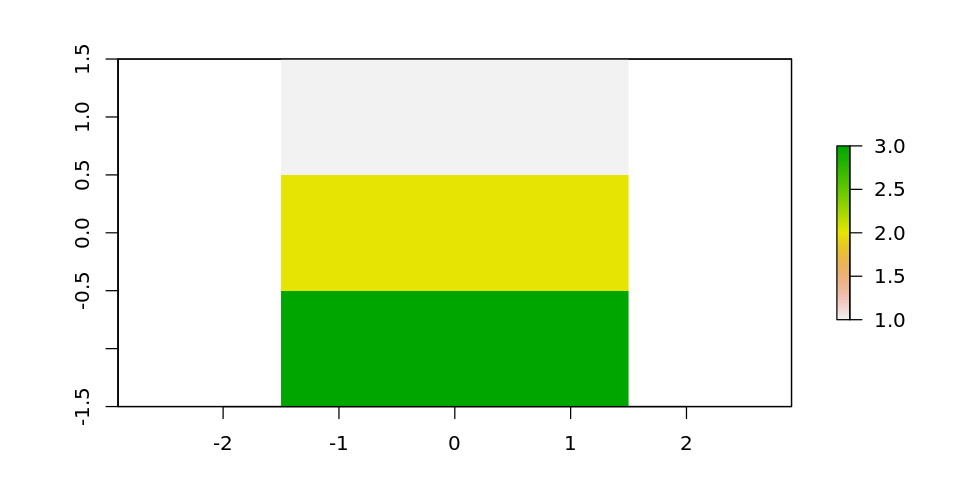

In [56]:
# reclassify with a reclassifying matrix
rcl = matrix(c(0, 12, 1, 12, 24, 2, 24, 36, 3), ncol = 3, byrow = TRUE)
rcl
area_rcl = reclassify(area, rcl = rcl)
plot(area_rcl)

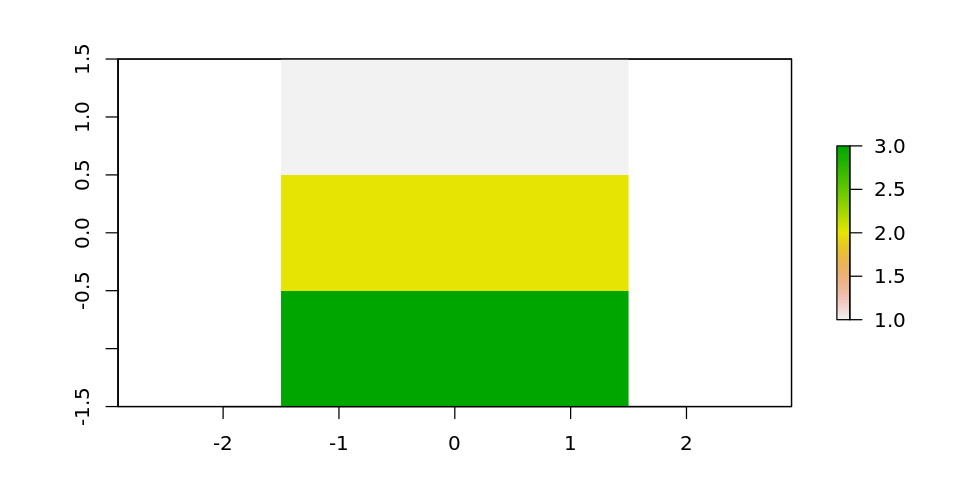

In [57]:
# reclassify with cut function
breaks <- c(0, 12, 24, 36)
area_cut <- cut(area, breaks=breaks)
plot(area_cut)

<a id="Ex3"></a>
### **<span style='color:Green'> Exercise 3: Geometry operations </span>**   

In this exercise, we will practice geometry operations using MN SPAM raster on maize harvested area and production.

**Step 1:** Use `aggregate()` function to create a new RasterLayer from `spam_Y_MAIZ_A_mn` which has a resolution that is 2x lower than the original (use mean value for the new aggregated raster cells).

Plot the aggregated maize yield raster map, check the number of cells in the new rasterlayer and look at the histogram for yield distribution, comparing your results with the original raster


[1] 1692

[1] 6603

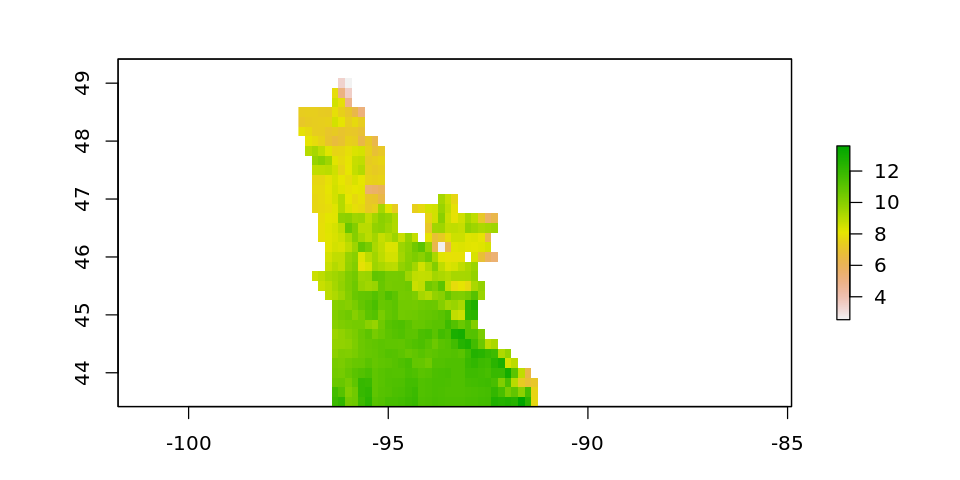

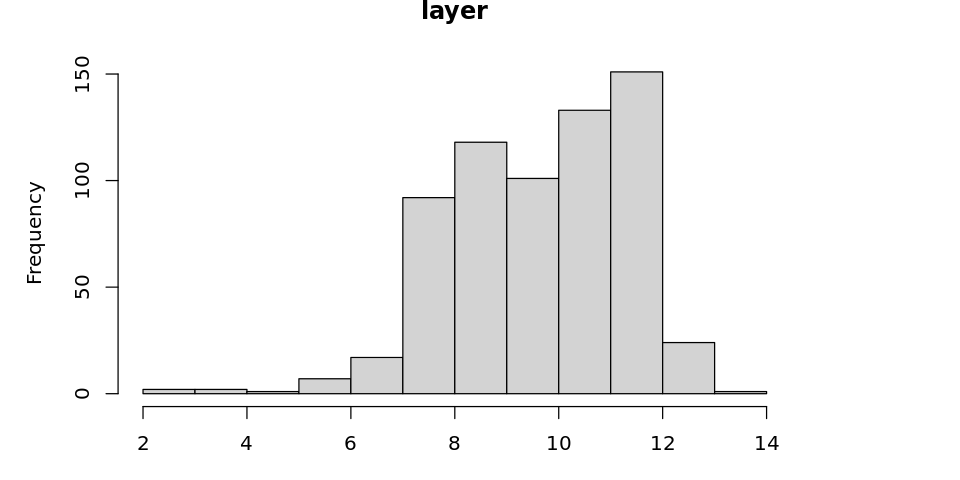

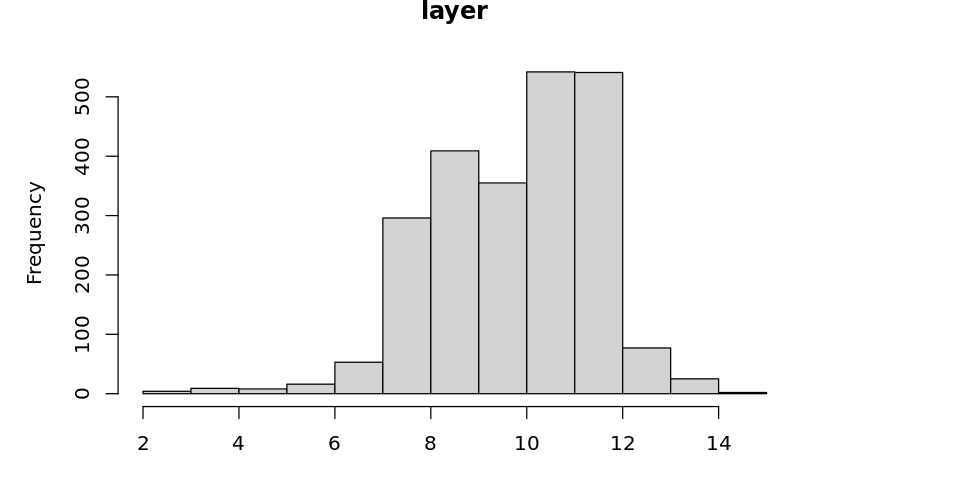

In [58]:
# Aggregate raster files
spam_Y_MAIZ_A_mn_agg <- aggregate(spam_Y_MAIZ_A_mn, fact=2, fun=mean)

# Plot map
plot(spam_Y_MAIZ_A_mn_agg)

# Number of cells
ncell(spam_Y_MAIZ_A_mn_agg)
ncell(spam_Y_MAIZ_A_mn)

# Histogram
hist(spam_Y_MAIZ_A_mn_agg)
hist(spam_Y_MAIZ_A_mn)

<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
# Aggregate raster files
spam_Y_MAIZ_A_mn_agg <- aggregate(spam_Y_MAIZ_A_mn, fact=2, fun=mean)

# Plot map
plot(spam_Y_MAIZ_A_mn_agg)

# Number of cells
ncell(spam_Y_MAIZ_A_mn_agg)
ncell(spam_Y_MAIZ_A_mn)

# Histogram
hist(spam_Y_MAIZ_A_mn_agg)
hist(spam_Y_MAIZ_A_mn)
```
----
          
</details>

**Step 2:** Based on the yield distribution (histogram), use `reclassify()` or `cut()` function to create a RasterLayer which classifies the yield into "low", "mid", "high" groups. Choose your own breaks to do the grouping.

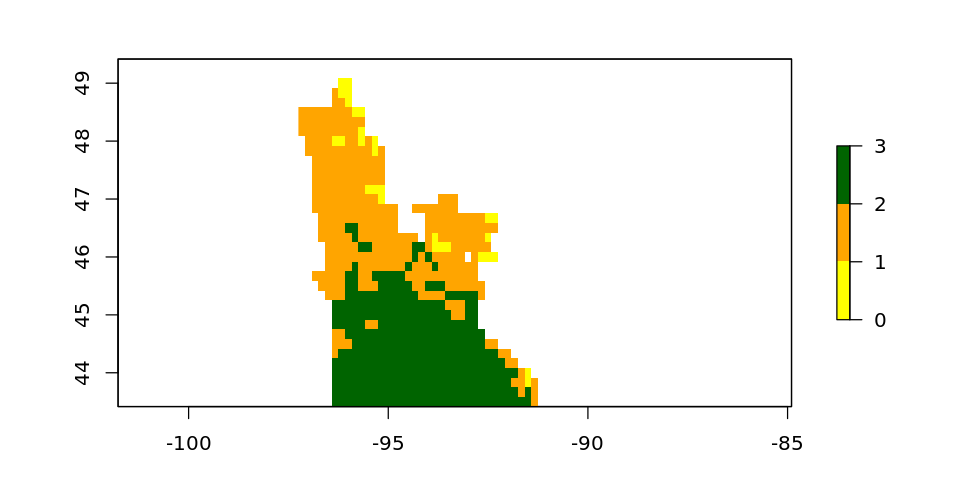

In [60]:
# reclassify() method
# reclassify() method
spam_Y_MAIZ_A_mn_agg_rcl = reclassify(spam_Y_MAIZ_A_mn_agg, rcl =  matrix(c(0, 7, 1, 7, 10, 2, 10, 15, 3), ncol = 3, byrow = TRUE))
plot(spam_Y_MAIZ_A_mn_agg_rcl, breaks=c(0, 1, 2, 3), col = c('yellow', 'orange', 'dark green'))

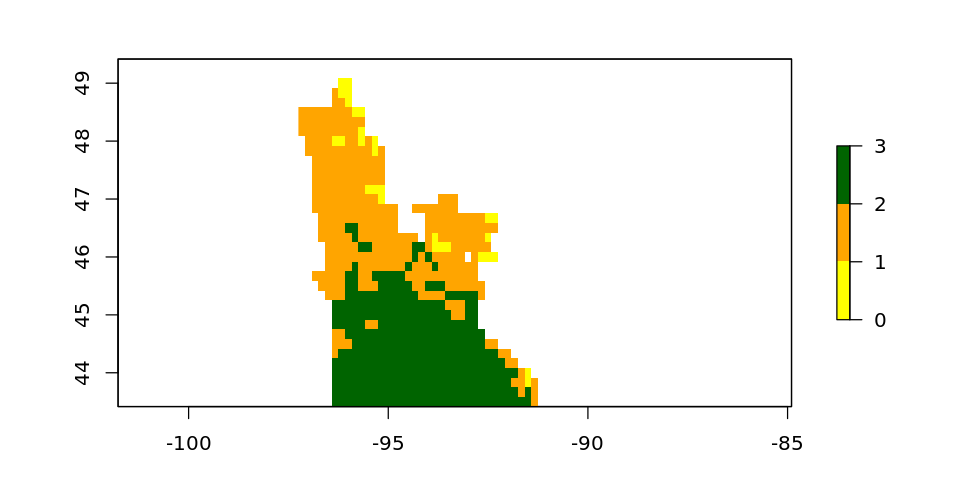

In [59]:
# cut() method


# cut() method
spam_Y_MAIZ_A_mn_agg_cut = cut(spam_Y_MAIZ_A_mn_agg, breaks=c(0, 7, 10, 15))
plot(spam_Y_MAIZ_A_mn_agg_cut, breaks=c(0, 1, 2, 3), col = c('yellow', 'orange', 'dark green'))

<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
# reclassify() method
spam_Y_MAIZ_A_mn_agg_rcl = reclassify(spam_Y_MAIZ_A_mn_agg, rcl =  matrix(c(0, 7, 1, 7, 10, 2, 10, 15, 3), ncol = 3, byrow = TRUE))
plot(spam_Y_MAIZ_A_mn_agg_rcl, breaks=c(0, 1, 2, 3), col = c('yellow', 'orange', 'dark green'))

# cut() method
spam_Y_MAIZ_A_mn_agg_cut = cut(spam_Y_MAIZ_A_mn_agg, breaks=c(0, 7, 10, 15))
plot(spam_Y_MAIZ_A_mn_agg_cut, breaks=c(0, 1, 2, 3), col = c('yellow', 'orange', 'dark green'))

```
----
          
</details>

<a id="RasVec"></a>

## **Raster-vector interactions**

### Cropping and masking
When the extent of input raster objects are larger than area of interest raster **cropping** and **masking** are useful for unifying the spatial extent of input data.


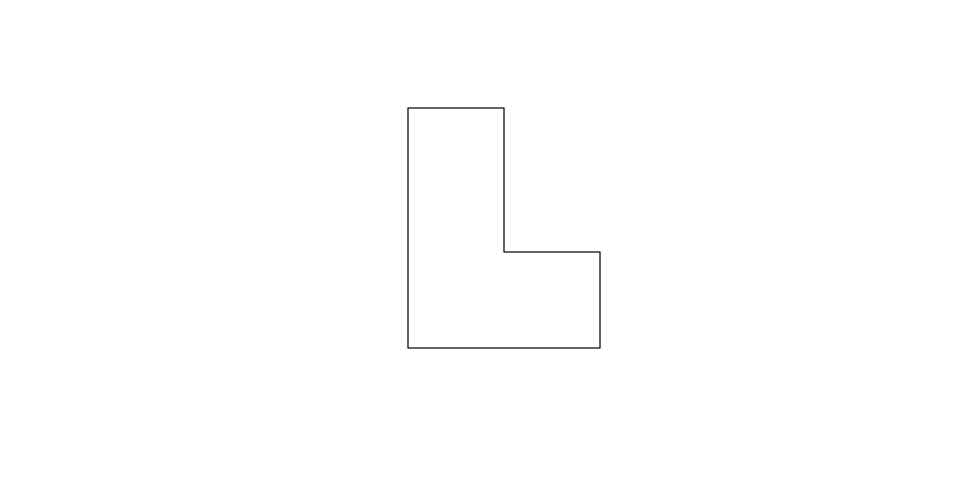

In [61]:
# SpatialPolygons for cropping/masking 
px <- c(0, 0, 1, 1, -1, -1) 
py <- c(1.5, 0, 0, -1, -1, 1.5) 
area_pol <- SpatialPolygons(list(Polygons(list(Polygon(cbind(px,py))), ID="A")))
crs(area_pol) <- crs(area)

# plot
plot(area_pol)

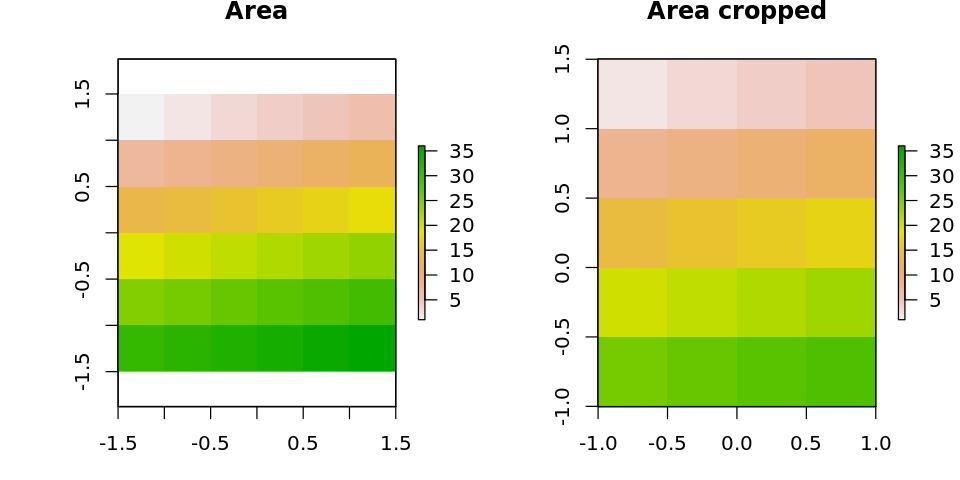

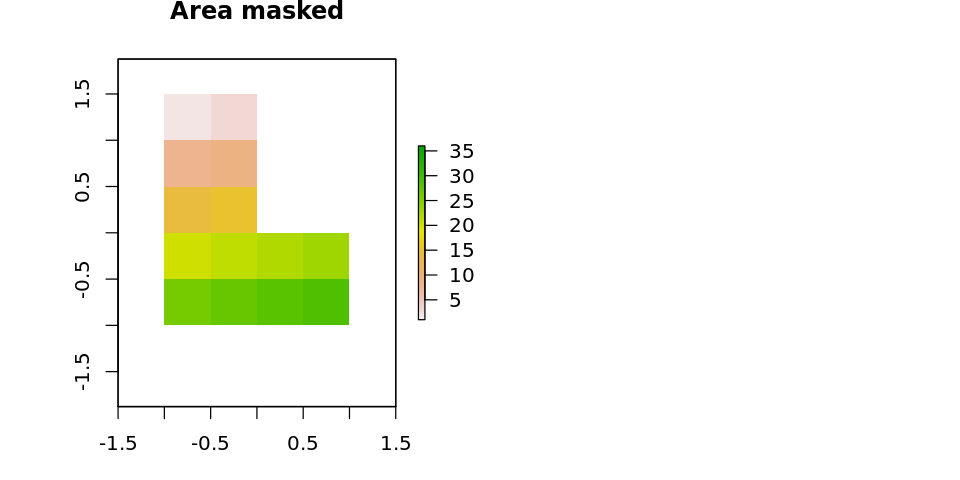

In [62]:
area_cropped = crop(area, area_pol)
area_masked = mask(area, area_pol)

par(mfrow=c(1,2))
plot(area, main="Area")
plot(area_cropped, main="Area cropped", zlim=c(1, 36))
plot(area_masked, main="Area masked", zlim=c(1, 36))

## Raster extraction

Raster extraction is the process of identifying and returning the values associated with a 'target' raster at specific locations.

In [63]:
# total area within selected shape
extract(area, area_pol, fun=sum, na.rm=T, df=T)

ID,layer
<int>,<dbl>
1,247


## Rasterization  

Rasterization is the conversion of vector objects into their representation in raster objects.

The following code chunk rasterizes an input vector data using a template raster that has the same extent and CRS:

class      : RasterLayer 
dimensions : 6, 6, 36  (nrow, ncol, ncell)
resolution : 0.5, 0.5  (x, y)
extent     : -1.5, 1.5, -1.5, 1.5  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
source     : memory
names      : layer 
values     : 1, 1  (min, max)


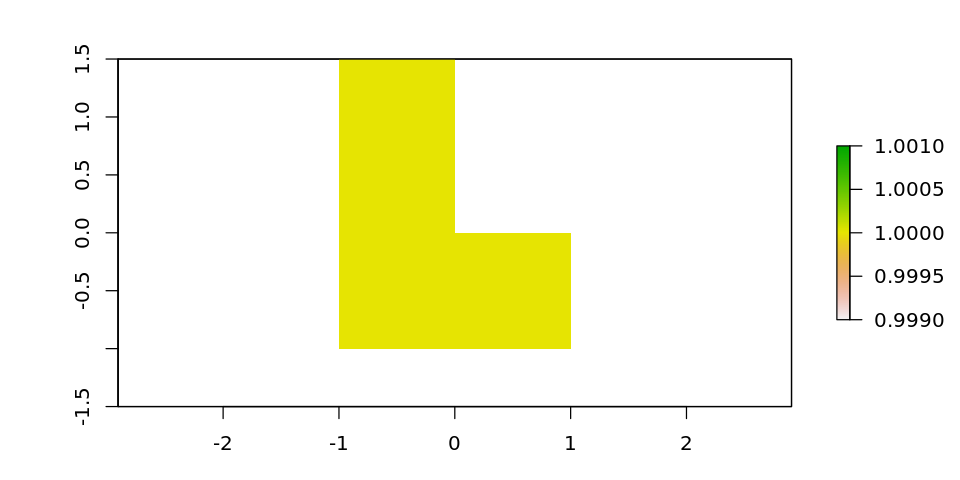

In [64]:
area_pol_ras <- rasterize(area_pol, area)
area_pol_ras
plot(area_pol_ras)

<a id="Ex4"></a>
### **<span style='color:Green'> Exercise 4: Raster-vector interactions </span>**   

In this exercise, we will practice raster-vector interactions

**Step 1:** Read in MN ground water shapefile and select ground water provinces 1,2,3 to mask out maize production raster

- Use `st_read()` function to read in the MN ground water shapefile from `./data/MN/gw_prov`
- Plot the `PROVINCE` attribute using `tmap`.
- Create a subset of ground water PROVINCE 1,2,3 shapefile
- Use `mask` to mask out only maize production in ground water PROVINCE 1,2,3 


In [65]:
gw_prov <- st_read("./data/MN/gw_prov")
summary(gw_prov)

Reading layer `gw_provinces_extra' from data source 
  `/home/u01000040/classes/GEMSX003/GEMS-Learning-R-Geospatial-Raster/data/MN/gw_prov' 
  using driver `ESRI Shapefile'
Simple feature collection with 42 features and 6 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 189775.3 ymin: 4816307 xmax: 761655.1 ymax: 5472236
Projected CRS: NAD83 / UTM zone 15N


   PROVINCE           Shape_Leng        Shape_Area            var1          
 Length:42          Min.   :  18672   Min.   :1.170e+07   Length:42         
 Class :character   1st Qu.:  48939   1st Qu.:5.776e+07   Class :character  
 Mode  :character   Median :  90860   Median :1.728e+08   Mode  :character  
                    Mean   : 389743   Mean   :5.173e+09                     
                    3rd Qu.: 216812   3rd Qu.:9.189e+08                     
                    Max.   :2921536   Max.   :7.389e+10                     
     var2                var3                 geometry 
 Length:42          Min.   : 86.55   MULTIPOLYGON :42  
 Class :character   1st Qu.:214.59   epsg:26915   : 0  
 Mode  :character   Median :240.79   +proj=utm ...: 0  
                    Mean   :238.41                     
                    3rd Qu.:240.79                     
                    Max.   :353.44                     

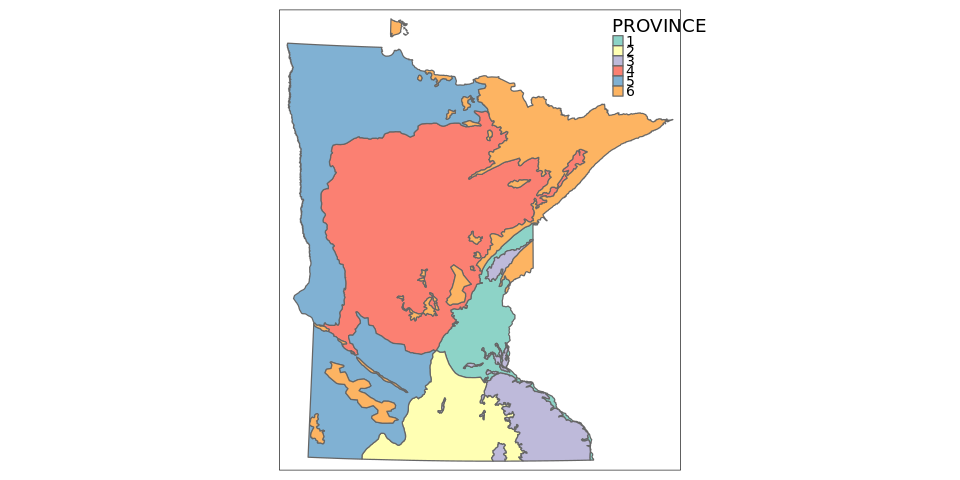

In [66]:
# Plot
tm_shape(gw_prov) +
  tm_polygons("PROVINCE")


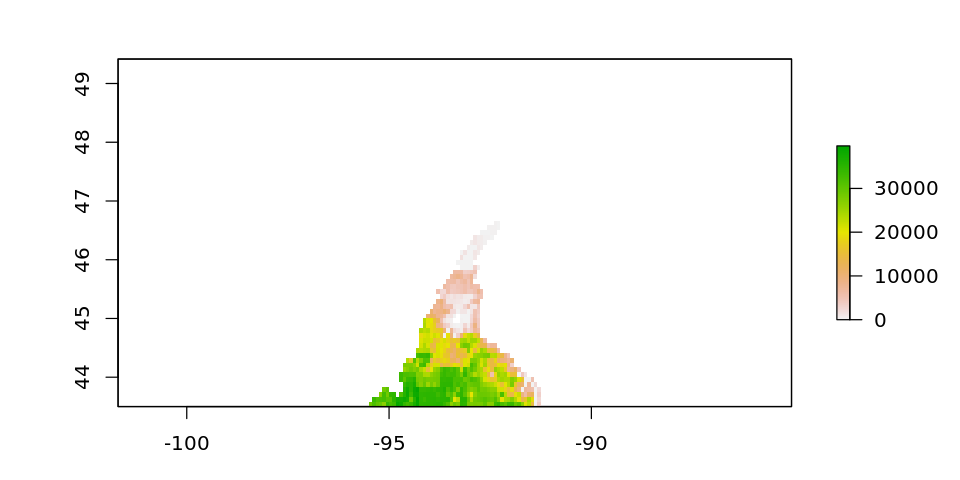

In [68]:
# Subset PROVINCE 1, 2, 3
gw_prov123 <- gw_prov[gw_prov$PROVINCE %in% c("1", "2", "3"), ]

# mask
gw_prov123 <- st_transform(gw_prov123, crs=crs(spam_P_MAIZ_A_mn))
spam_P_MAIZ_A_mn_mask <- mask(spam_P_MAIZ_A_mn, gw_prov123)

plot(spam_P_MAIZ_A_mn_mask)

<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
library(sf)

# Read in MN ground water shapefile
gw_prov <- st_read("./data/MN/gw_prov")
summary(gw_prov)

# Plot
tm_shape(gw_prov) +
  tm_polygons("PROVINCE")

# Subset PROVINCE 1, 2, 3
gw_prov123 <- gw_prov[gw_prov$PROVINCE %in% c("1", "2", "3"), ]

# mask
gw_prov123 <- st_transform(gw_prov123, crs=crs(spam_P_MAIZ_A_mn))
spam_P_MAIZ_A_mn_mask <- mask(spam_P_MAIZ_A_mn, gw_prov123)

plot(spam_P_MAIZ_A_mn_mask)
```
----
          
</details>

**Step 2:** Use `extract()` to calculate the total maize production within each of the MN water provinces 1, 2, 3
- What's the dimension of the output from `extract()`? Why is that? 
- Add in the "PROVINCE" column to the output data.frame from `extract()`
- Sum by "PROVINCE" to get the province-level total production

In [69]:
# extract()
geom_sum <- extract(spam_P_MAIZ_A_mn_mask, gw_prov123, fun=sum, na.rm=T, df=T)
geom_sum

# Province level total production
geom_sum$PROVINCE <- gw_prov123$PROVINCE
geom_sum <- as.data.table(geom_sum)
geom_sum[, .(PROD_TOT = sum(spam_P_MAIZ_A_mn)), by=.(PROVINCE)]

ID,spam_P_MAIZ_A_mn
<int>,<dbl>
1,1056316.2
2,8891431.9
3,9089.9
4,125818.3
5,95072.9
6,5445.3
7,213056.8
8,3303770.9
9,76127.1


PROVINCE,PROD_TOT
<chr>,<dbl>
1,1056316
2,8891432
3,3895039


In [71]:
gw_prov123$PROVINCE

[1] "1" "2" "3" "3" "3" "3" "3" "3" "3" "3" "3" "3" "3" "3"

<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
# extract()
geom_sum <- extract(spam_P_MAIZ_A_mn_mask, gw_prov123, fun=sum, na.rm=T, df=T)
geom_sum

# Province level total production
geom_sum$PROVINCE <- gw_prov123$PROVINCE
geom_sum <- as.data.table(geom_sum)
geom_sum[, .(PROD_TOT = sum(spam_P_MAIZ_A_mn)), by=.(PROVINCE)]

```
----
          
</details>

**Step 2:** Use `rasterize()` to calculate the total maize production within MN water provinces 1, 2, 3
- To use `rasterize()`, first need to convert province character to numeric `PROVINCE_CODE`, then rasterize on this field using either min or max function
- Recall we can use `zonal()` function to aggregate one raster (i.e., production) based on another raster (i.e., provinces)
- Compare your results with the `extract()` method

zone,sum
1,1056316
2,8891432
3,3581175


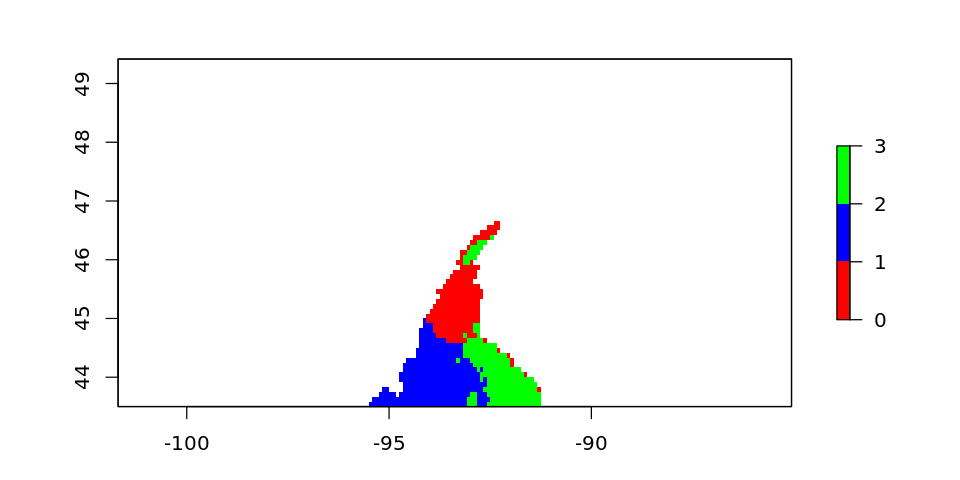

In [72]:
# rasterize()
gw_prov123$PROVINCE_CODE <- as.numeric(gw_prov123$PROVINCE)
gw_prov123_ras <- rasterize(gw_prov123, spam_P_MAIZ_A_mn_mask, field="PROVINCE_CODE", fun=min)
plot(gw_prov123_ras, breaks=c(0, 1, 2, 3), col=c("red", "blue", "green"))

# zonal calculation
gw_prov123_zonal <- zonal(spam_P_MAIZ_A_mn_mask, gw_prov123_ras, fun = "sum") 
gw_prov123_zonal

<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
# rasterize()
gw_prov123$PROVINCE_CODE <- as.numeric(gw_prov123$PROVINCE)
gw_prov123_ras <- rasterize(gw_prov123, spam_P_MAIZ_A_mn_mask, field="PROVINCE_CODE", fun=min)
plot(gw_prov123_ras, breaks=c(0, 1, 2, 3), col=c("red", "blue", "green"))

# zonal calculation
gw_prov123_zonal <- zonal(spam_P_MAIZ_A_mn_mask, gw_prov123_ras, fun = "sum") 
gw_prov123_zonal
```
----
          
</details>

<a id="Ex5"></a>
### **<span style='color:Green'> At-home Exercise: Learn `terra`  </span>**   

Now that you are familiar with raster data operations in R, it is recommended that you learn `terra` on your own and start use R for raster data analysis for your own work.

Some useful resources to get you started  
>**[The `terra` package](https://rspatial.org/terra/pkg/index.html)**  

>**[A comparison of terra and raster packages](https://www.r-bloggers.com/2021/05/a-comparison-of-terra-and-raster-packages/)**  

>**[Spatial Data Science with R and “terra”](https://rspatial.org/terra/index.html)**

